In [1]:
import heeps
from heeps.util.multiCPU import multiCPU
from copy import deepcopy
import proper
%matplotlib inline

## Input parameters

In [2]:
nimg = 720
nframes = 100
nzers = 20
dir_current = '$HOME/heeps_metis'
scao = 'input_files/wavefront/cube_Cbasic_20210504_600s_100ms_0piston_meters_scao_only_%s_WV.fits'%nimg
mask = 'input_files/wavefront/mask_Cbasic_20210504_%s.fits'%nimg
dir_current = os.path.normpath(os.path.expandvars(dir_current))
cube = fits.getdata(os.path.join(dir_current, scao))
pup = fits.getdata(os.path.join(dir_current, mask))


In [3]:
def get_piston(frame):
    return np.mean(frame[frame!=0])
def get_rms(frame):
    return np.std(frame[frame!=0])
def get_zpols(nzer, pup, phi):
    zpols = proper.prop_fit_zernikes(phi, pup, nimg/2, nzer, eps=0, fit=True)
    return zpols
def remove_zernike(wf, pup, phi, zpols):
    proper.prop_add_phase(wf, phi)
    phiz = proper.prop_zernikes(wf, np.arange(len(zpols)) + 1, zpols)
    phiz[pup==0] = 0
    phih = phi - phiz    
    return phiz, phih

## Zernike polynomials

In [4]:
zpols = multiCPU(get_zpols, posargs=[nzers, pup], posvars=[cube[0:nframes]], case='get zpols')
wf = proper.prop_begin(nimg, 1, nimg, 1)
LSFs = np.empty((nzers, nframes, nimg, nimg))
HSFs = np.empty((nzers, nframes, nimg, nimg))
LSFs_rms = []
HSFs_rms = []
print('remove zernikes: %s simulations'%nzers)
for i,z in enumerate(np.arange(nzers)):
    verbose = False if i > 0 else True
    phiz, phih = multiCPU(remove_zernike, posargs=[deepcopy(wf), pup], posvars=[cube[0:nframes], zpols[:,:z+1]], \
        case='remove zernike', nout=2, verbose=verbose)
    LSFs[z], HSFs[z] = phiz, phih
    LSFs_rms.append(np.mean(multiCPU(get_rms, posvars=[phiz], case='get rms', verbose=verbose)))
    HSFs_rms.append(np.mean(multiCPU(get_rms, posvars=[phih], case='get rms', verbose=verbose)))
    print(i+1, end=', ')

   2021-05-12 14:30:09, get zpols using 12 cores
   2021-05-12 14:30:29, completed in 20.59 seconds
remove zernikes: 20 simulations
   2021-05-12 14:30:29, remove zernike using 12 cores
   2021-05-12 14:30:33, completed in 3.42 seconds
   2021-05-12 14:30:33, get rms using 12 cores
   2021-05-12 14:30:34, completed in 1.37 seconds
   2021-05-12 14:30:34, get rms using 12 cores
   2021-05-12 14:30:36, completed in 1.34 seconds
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

### One frame example

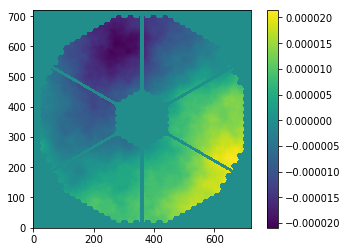

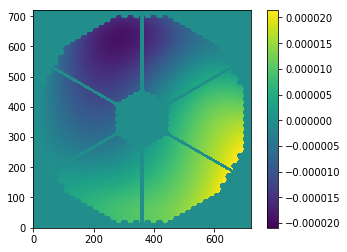

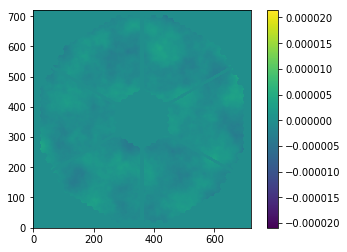

In [5]:
i=0
z=-1
plt.figure(), plt.imshow(cube[i], origin=True), plt.colorbar();
vmin, vmax = plt.gci().get_clim()
plt.figure(), plt.imshow(LSFs[z,i], origin=True, vmin=vmin, vmax=vmax), plt.colorbar();
plt.figure(), plt.imshow(HSFs[z,i], origin=True, vmin=vmin, vmax=vmax), plt.colorbar();

### PSD

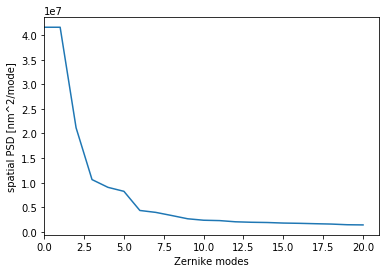

In [6]:
PSD = [(HSFs_rms[0]*1e9)**2]
for rms in HSFs_rms:
    PSD.append((rms*1e9)**2)
plt.plot(np.arange(nzers+1), PSD)
plt.xlabel('Zernike modes')
plt.ylabel('spatial PSD [nm^2/mode]')
#plt.ylim(bottom=0);
plt.xlim(left=0);